# DTSA 5011 Introduction to Deep Learning Final Project

![](https://raw.githubusercontent.com/cloud-erik/5510/main/boulder.jpg)



Manny thanks to Titouan Lorieul. I used his great getting startet notbooks related to this competition

- https://www.kaggle.com/code/tlorieul/geolifeclef2022-data-loading-and-visualization
- https://www.kaggle.com/code/tlorieul/geolifeclef2022-baselines-and-submission

to get a quick start with the complex structure of the data provided.

# About the project

I decided to go as final project for a challanging Kagggle competition GeoLifeCLEF 2022 - LifeCLEF 2022 x FGVC9, Location-based species presence prediction https://www.kaggle.com/competitions/geolifeclef-2022-lifeclef-2022-fgvc9.

The aim of this competition is to predict the localization of plant and animal species.
To do so, 1.6M geo-localized observations from France and the US of 17K species are provided (9K plant species and 8K animal species).
These observations are paired with aerial images and environmental features around them.
The goal is, for each GPS position in the test set (for which we provide the associated aerial images and environmental features), to return a set of candidate species that should contain the true observed species. 

The competition is part of the CLEF 2022 Conference and Labs of the Evaluation Forum (https://clef2022.clef-initiative.eu/)

There is also an additional github repository for this competition with relevant helper functions to handle the data: https://github.com/maximiliense/GLC



# Data
The available data for ntraining consits of 1.6 million of geo-localized observations of plants and animals in the US and France.

There are 17K species in the dataset, 9K plant species and 8K animal species.

Each observation consists of a species name with the GPS coordinates where it was observed.

Also for every location there is a
- RGB satellite image,
- a near IR satellite image,
- a map with the altitude,
- a map with land cover
- and 19 low-resolution rasters with Bioclimatic data
- and 8 low-resolution rasters with Pedologic data

provided. In full we have more as 61 GB of data available for training and testing.

# Approch

Because this is the final project of the deep learning course I will choose a deep learning approch. I will try to build a CNN that is able to classify the stacked RGB, IR, altitude and land cover images. So Input will be an image with resolution of 256x256 pixels and 6 channels. After the covolution layers I will merge this network with a second deep dense network that takes the Bioclimatic and Pedologic data of the observasion and geolocation as a kind of matadata also into account. The joined network than should be responsible for the final prediction.

I am fully aware that this is a complex and also computational challanging project and I hope I will be able to get it at least somehow to an end. And it would be fantastic but illosoric if I could produce a competable submission.

# Loading and analysing data
Start with the data structure and  load the data.

In [1]:
# for performace patch
# !pip install scikit-learn-intelex
# from sklearnex import patch_sklearn
# patch_sklearn() # with larger no of trees kernel dies
 
# disable  patching
#from sklearnex import unpatch_sklearn
#unpatch_sklearn()

In [2]:
# set Kaggle API for download and submission
from kaggle.api.kaggle_api_extended import KaggleApi

# Download data

I downloaded the data locally and saved it into my workdir of the project.

In [3]:
# User and API key is stored in config
import config
import os

# for extracting the downloaded data
import zipfile

%pylab inline --no-import-all
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
#import numpy.typing as npt

from pathlib import Path

# set user and API key
os.environ['KAGGLE_USERNAME'] = config.KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = config.KAGGLE_KEY

api = KaggleApi()
api.authenticate()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
# Create the path to save input files
os.makedirs("input", exist_ok=True)

competition_file = "geolifeclef-2022-lifeclef-2022-fgvc9"

# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./input/" + competition_file + "/")

# Download competition files in data director
# Dowanload only if not already done
if not ( os.path.exists(DATA_PATH) \
    or os.path.exists("./input/" + competition_file + ".zip")):
        api.competition_download_files(competition_file, path="input")

# unzip files if not already done
if not os.path.exists(DATA_PATH):
#    !unzip -d data "./input/" + competition_file + ".zip"
    with zipfile.ZipFile("./input/" + competition_file + ".zip") as z:
        z.extractall(DATA_PATH)
# And remove zip file    
    os.remove("./input/" + competition_file + ".zip")

We need to clone the github repository of the project

In [5]:
!rm -rf GLC

# for current maser
!git clone https://github.com/maximiliense/GLC

# taking old branch
#!git clone -b GeoLifeCLEF2021 https://github.com/maximiliense/GLC    


Cloning into 'GLC'...


This folder is the path root where the data was downloaded and extracted:

In [6]:
#ls -L $DATA_PATH

We can now look into these subfolders and the data they contain.

# Observations

The `observations` subfolder contains 4 CSV files:

In [7]:
#ls $DATA_PATH\observations

Each of line of those files corresponds to a single observation.

In the files corresponding to the training data, there are 5 columns:
- `observation_id`: unique identifier of the observation
- `latitude`: latitude coordinates of this observation
- `longitude`: longitude coordinates of this observation
- `species_id`: identifier of the species observed at that location
- `subset`: proposed train/val split using the same splitting procedure than for train and test (equal to either "train" or "val")

In the files corresponding to the test data, there are only 3 columns:
- `observation_id`: unique identifier of the observation
- `latitude`: latitude coordinates of this observation
- `longitude`: longitude coordinates of this observation

The goal is then to predict the identifier of the species observed at that location.

Let's load these CSV files using [pandas](https://pandas.pydata.org/):

In [8]:
import pandas as pd

In [9]:
df_obs_fr = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")

df_obs = pd.concat((df_obs_fr, df_obs_us))

print("Number of observations for training: {}".format(len(df_obs)))

df_obs.head()

Number of observations for training: 1627475


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


In [10]:
df_obs_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))

print("Number of observations for testing: {}".format(len(df_obs_test)))

df_obs_test.head()

Number of observations for testing: 36421


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


The observations are not uniformly sampled in the two countries as shown the following plots.
The training observations are shown in blue while the test ones are shown in red.

Important to make sure cartopy is installed properly. when using conda pleasd run

"conda install -c conda-forge cartopy"

Text(0.5, 1.0, 'Observations distribution (France)')

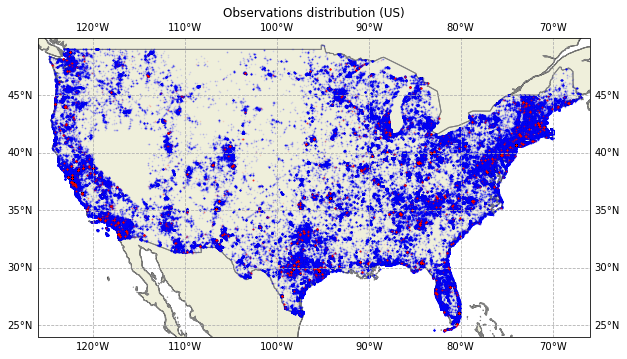

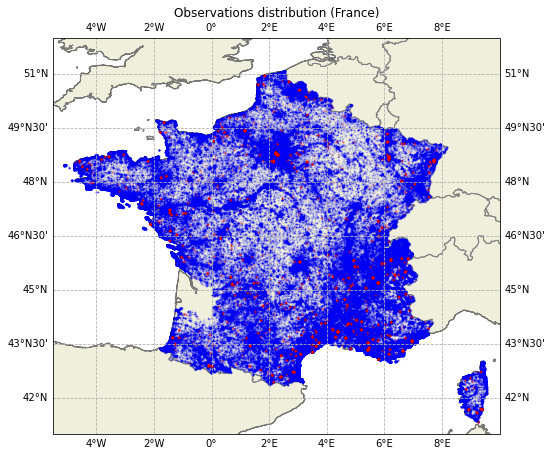

In [11]:
from GLC.plotting import plot_map


def plot_observations_distribution(ax, df_obs, df_obs_test=None, **kwargs):
    default_kwargs = {
        "zorder": 1,
        "alpha": 0.1,
        "s": 0.5
    }
    default_kwargs.update(kwargs)
    kwargs = default_kwargs
    
    ax.scatter(df_obs.longitude, df_obs.latitude, color="blue", **kwargs)
    
    if df_obs_test is not None:
        ax.scatter(df_obs_test.longitude, df_obs_test.latitude, color="red", **kwargs)


fig = plt.figure(figsize=(10, 5.5))
ax = plot_map(region="us")
plot_observations_distribution(ax, df_obs_us, df_obs_us_test)
ax.set_title("Observations distribution (US)")

fig = plt.figure(figsize=(8, 8))
ax = plot_map(region="fr")
plot_observations_distribution(ax, df_obs_fr, df_obs_fr_test)
ax.set_title("Observations distribution (France)")

A close-up view on the region around Montpellier, France, shows the train/test splitting procedure.

Note that there is no geographical overlap between training and test sets.

Text(0.5, 1.0, 'Observations distribution around Montpellier, France')

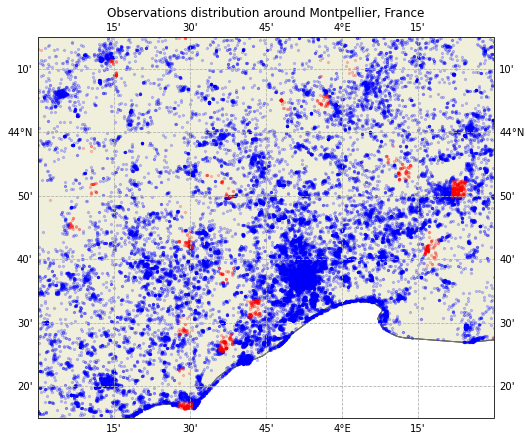

In [12]:
def select_samples_around_point(df_obs, lon_min, lon_max, lat_min, lat_max):
    ind = (
        (lon_min <= df_obs.longitude) & (df_obs.longitude <= lon_max)
        & (lat_min <= df_obs.latitude) & (df_obs.latitude <= lat_max)
    )
    return df_obs[ind]


extent = [3, 4.5, 43.25, 44.25]

fig = plt.figure(figsize=(9.5, 7))
ax = plot_map(extent=extent)

df_obs_zoom = select_samples_around_point(df_obs_fr, *extent)
df_obs_zoom_test = select_samples_around_point(df_obs_fr_test, *extent)

kwargs = {
    "alpha": 0.2,
    "s": 5,
}
plot_observations_distribution(ax, df_obs_zoom, df_obs_zoom_test, **kwargs)
ax.set_title("Observations distribution around Montpellier, France")

The dataset contains 17K species and is imbalanced.

Total number of species: 17037


(1, 6701.000000000001)

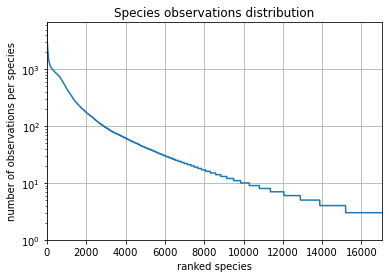

In [13]:
species_value_counts = df_obs["species_id"].value_counts()

print("Total number of species: {}".format(len(species_value_counts)))


fig = plt.figure()
ax = fig.gca()

x = np.arange(len(species_value_counts))
ax.plot(x, species_value_counts)

ax.set_yscale("log")

ax.set_xlabel("ranked species")
ax.set_ylabel("number of observations per species")
ax.set_title("Species observations distribution")

ax.grid()
ax.autoscale(tight=True)
ax.set_ylim(bottom=1)

# Metadata

In the `metadata` folder, some additional data is provided.
There are 4 files containing:
1. GBIF species, genus, families and kingdom names associated with the species id provided in the observations in `species_details.csv`
2. The description of the environmental (bioclimatic and pedological) variables in `environmental_variables.csv`
3. The labels corresponding to the original land cover codes in `landcover_original_labels.csv`
4. The suggested alignment of land cover codes between France and US in `landcover_suggested_alignment.csv`

In [14]:
df_species = pd.read_csv(DATA_PATH / "metadata" / "species_details.csv", sep=";")

print("Total number of species: {}".format(len(df_species)))

print("\nNumber of species in each kingdom:")
print(df_species.GBIF_kingdom_name.value_counts())

df_species.head()

Total number of species: 17037

Number of species in each kingdom:
Plantae     9080
Animalia    7957
Name: GBIF_kingdom_name, dtype: int64


,species_id,GBIF_species_id,GBIF_species_name,GBIF_genus_name,GBIF_family_name,GBIF_kingdom_name
0,0,5356345,Laburnum anagyroides,Laburnum,Fabaceae,Plantae
1,1,2874515,Cucurbita maxima,Cucurbita,Cucurbitaceae,Plantae
2,2,2874569,Cucumis sativus,Cucumis,Cucurbitaceae,Plantae
3,3,3033363,Ranunculus acris,Ranunculus,Ranunculaceae,Plantae
4,4,3034830,Heracleum sphondylium,Heracleum,Apiaceae,Plantae


In [15]:
df_obs = df_obs.reset_index().merge(df_species, on="species_id", how="left").set_index(df_obs.index.names)

print("Number of observations of each kingdom:")
print(df_obs.GBIF_kingdom_name.value_counts())

df_obs.head()

Number of observations of each kingdom:
Plantae     1132257
Animalia     495218
Name: GBIF_kingdom_name, dtype: int64


,latitude,longitude,species_id,subset,GBIF_species_id,GBIF_species_name,GBIF_genus_name,GBIF_family_name,GBIF_kingdom_name
observation_id,,,,,,,,,
10561949,45.705116,1.424622,241,train,3093911,Hypochaeris glabra,Hypochaeris,Asteraceae,Plantae
10131188,45.146973,6.416794,101,train,5371685,Caltha palustris,Caltha,Ranunculaceae,Plantae
10799362,46.783695,-2.072855,700,train,3889056,Perovskia atriplicifolia,Perovskia,Lamiaceae,Plantae
10392536,48.604866,-2.825003,1456,train,3189497,Hypericum calycinum,Hypericum,Hypericaceae,Plantae
10335049,48.815567,-0.161431,157,train,3152379,Malva moschata,Malva,Malvaceae,Plantae


In [16]:
df_env_vars = pd.read_csv(DATA_PATH / "metadata" / "environmental_variables.csv", sep=";")
df_env_vars.head()

,name,description,resolution
0,bio_1,Annual Mean Temperature,30 arcsec
1,bio_2,Mean Diurnal Range (Mean of monthly (max temp ...,30 arcsec
2,bio_3,Isothermality (bio_2/bio_7) (* 100),30 arcsec
3,bio_4,Temperature Seasonality (standard deviation * ...,30 arcsec
4,bio_5,Max Temperature of Warmest Month,30 arcsec


In [17]:
df_landcover_labels = pd.read_csv(DATA_PATH / "metadata" / "landcover_original_labels.csv", sep=";")
df_landcover_labels.head()

,landcover_code,original_landcover_code,landcover_label
0,0,0,Missing Data
1,1,11,Annual Summer Crops
2,2,12,Annual Winter Crops
3,3,31,Broad-leaved Forests
4,4,32,Coniferous Forests


In [18]:
df_suggested_landcover_alignment = pd.read_csv(DATA_PATH / "metadata" / "landcover_suggested_alignment.csv", sep=";")
df_suggested_landcover_alignment.head()

,landcover_code,suggested_landcover_code,suggested_landcover_label
0,0,0,Missing Data
1,1,11,Cultivated Crops
2,2,11,Cultivated Crops
3,3,6,Broad-leaved Forest
4,4,7,Coniferous Forest


# Patches

The patches consist of images centered at each observation's location capturing three types of information in the 250m x 250m neighboring square:
1. remote sensing imagery under the form of RGB-IR images
2. land cover data
3. altitude data

They are located in the two subfolder `patches-fr` and `patches-us`, one for each country:

In [19]:
#ls $DATA_PATH

The first digit of the observation id tells the country it belongs to:
- `1` for France, thus to be found in subfolder `patches-fr`
- `2` for US, thus to be found in subfolder `patches-us`

For instance, `10561900` is an observation made in France (on the Pic Saint-Loup mountain) whereas `22068175` was observed in the US.

Inside those folders, there are two levels of hierarchy, corresponding to the last four digits of the observation id:

In [20]:
#ls $DATA_PATH\patches-fr

and

In [21]:
#ls $DATA_PATH\patches-fr\00

To find the files corresponding to an observation:
1. the first subfolder corresponds to the last two digits,
2. the second subfolder corresponds to the two digits right before them.

For instance, the patches corresponding to observation `10171444` can be found in `patches-fr/44/14`, whereas `22068100` can be found in `patches-us/00/81`:

In [22]:
#ls $DATA_PATH/patches-fr/44/14/10171444*

and

In [23]:
#ls $DATA_PATH/patches-us/00/81/22068100*

There are 4 files for each observation:
- a color JPEG image containing an RGB image (`*_rgb.jpg`)
- a grayscale JPEG image containing a near-infrared image (`*_near_ir.jpg`)
- a TIFF with Deflate compression containing altitude data (`*_altitude.tif`)
- a TIFF with Deflate compression containing land cover data (`*_landcover.tif`)

We provide a loading function which, given an observation id, loads all this data at once using [Pillow](https://pillow.readthedocs.io/en/stable/) for the images and [tiffile](https://github.com/cgohlke/tifffile) for the TIFF files and returns them as a tuple `(rgb, near-ir, altitude, landcover)`:

In [24]:
from GLC.data_loading.common import load_patch

patch = load_patch(10171444, DATA_PATH)

print("Number of data sources: {}".format(len(patch)))
print("Arrays shape: {}".format([p.shape for p in patch]))
print("Data types: {}".format([p.dtype for p in patch]))

Number of data sources: 4
Arrays shape: [(256, 256, 3), (256, 256), (256, 256), (256, 256)]
Data types: [dtype('uint8'), dtype('uint8'), dtype('int16'), dtype('uint8')]


It can also automatically perform the land cover alignment if necessary:

In [25]:
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values
patch = load_patch(10171444, DATA_PATH, landcover_mapping=landcover_mapping)

In [26]:
df_suggested_landcover_alignment

,landcover_code,suggested_landcover_code,suggested_landcover_label
0,0,0,Missing Data
1,1,11,Cultivated Crops
2,2,11,Cultivated Crops
3,3,6,Broad-leaved Forest
4,4,7,Coniferous Forest
5,5,9,Natural Grassland/Herbaceous
6,6,8,Shrub/Scrub/Woodie Moorlands
7,7,5,Developed High Intensity
8,8,4,Developed Low Intensity
9,9,5,Developed High Intensity


We also provide an visualization function for the patches:

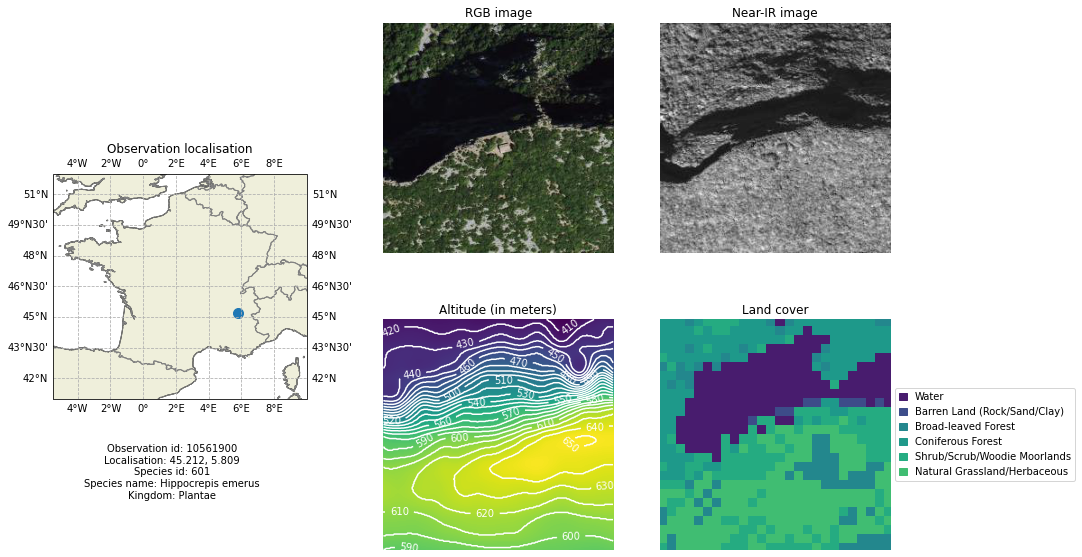

In [27]:
from GLC.plotting import visualize_observation_patch

# Extracts land cover labels
landcover_labels = df_suggested_landcover_alignment[["suggested_landcover_code", "suggested_landcover_label"]].drop_duplicates().sort_values("suggested_landcover_code")["suggested_landcover_label"].values

visualize_observation_patch(patch, observation_data=df_obs.loc[10561900], landcover_labels=landcover_labels)

Similarly, for the observation `22068100`:

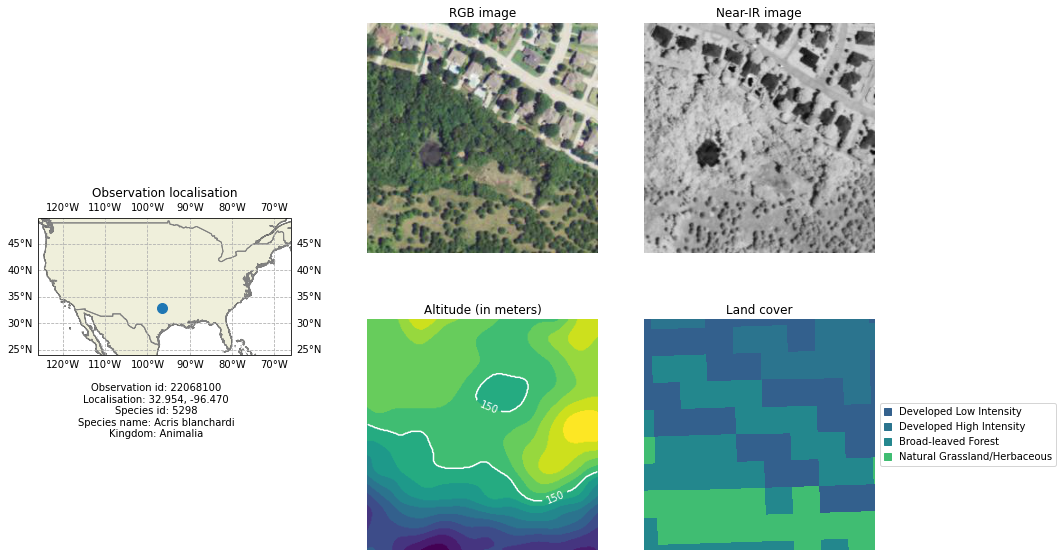

In [28]:
patch = load_patch(22068100, DATA_PATH, landcover_mapping=landcover_mapping)

visualize_observation_patch(patch, observation_data=df_obs.loc[22068100], landcover_labels=landcover_labels)

# Environmental rasters

The rasters contain low-resolution environmental data - bioclimatic and pedological data.

There are two ways to use this data:
1. directly use the environmental vectors pre-extracted that can be found in the CSV file `pre-extracted/environmental_vectors.csv`
2. manually extract patches centered at each observation using the rasters located in the `rasters` subfolder

## Pre-extracted environmental vectors

These vectors are ready to be used. They are easy to load as they are provided as a CSV file.

Each line of this file correspond to an observation and each column to one of the environmental variable.

In [29]:
df_env = pd.read_csv(DATA_PATH / "pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")
df_env.head()

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt
observation_id,,,,,,,,,,,,,,,,,,,,,
10000000,1.420833,6.908333,29.272598,614.14930,15.1,-8.5,23.600000,-1.000000,9.183333,9.466667,...,248.0,358.0,2082.0,988.0,29.0,13.0,63.0,62.0,34.0,53.0
10000001,8.837500,9.858334,37.771393,586.81390,23.8,-2.3,26.099998,6.016667,16.383333,16.383333,...,226.0,288.0,1816.0,1142.0,20.0,22.0,39.0,58.0,41.0,36.0
10000002,6.241667,8.350000,32.239384,632.86090,21.0,-4.9,25.900000,3.033333,14.200000,14.200000,...,268.0,317.0,1346.0,1075.0,29.0,22.0,54.0,59.0,40.0,38.0
10000003,12.554167,9.525001,40.189877,541.80865,25.9,2.2,23.699999,6.850000,19.350000,19.350000,...,157.0,257.0,1227.0,1383.0,21.0,28.0,18.0,71.0,46.0,25.0
10000004,8.029167,10.075000,36.636364,633.01750,23.7,-3.8,27.500000,4.616667,16.083334,16.083334,...,214.0,280.0,2833.0,1202.0,24.0,25.0,33.0,69.0,38.0,37.0


Note that it typically contains NaN values due to absence of data over the seas and oceans for both types of data as well as rivers and others for the pedologic data.

In [30]:
print("Variables which can contain NaN values:")
df_env.isna().any()

Variables which can contain NaN values:


bio_1     True
bio_2     True
bio_3     True
bio_4     True
bio_5     True
bio_6     True
bio_7     True
bio_8     True
bio_9     True
bio_10    True
bio_11    True
bio_12    True
bio_13    True
bio_14    True
bio_15    True
bio_16    True
bio_17    True
bio_18    True
bio_19    True
bdticm    True
bldfie    True
cecsol    True
clyppt    True
orcdrc    True
phihox    True
sltppt    True
sndppt    True
dtype: bool

## Patch extraction from rasters

To more easily extract patches from the rasters, we provide a `PatchExtractor` class which uses [rasterio](https://github.com/mapbox/rasterio).

In [31]:
#from GLC.data_loading.environmental_raster import PatchExtractor

The following code loads the rasters for all the variables and prepares to extract patches of size 256x256.

Here the patches are not of the same resolution as the provided ones as one pixel corresponds to 30arcsec (~1km) for the bioclimatic data and to 250m for the pedologic data.

Note that this uses quite a lot of memory (~18Go) as all the rasters will be loaded in the RAM.

To avoid this issue, we will only load the bioclimatic rasters here.

In [32]:
# extractor = PatchExtractor(DATA_PATH / "rasters", size=256)
# extractor.add_all_bioclimatic_rasters()

# print("Number of rasters: {}".format(len(extractor)))

To load all the rasters use:
```
extractor.add_all_rasters()
```
To load all the pedologic rasters use:
```
extractor.add_all_pedologic_rasters()`
```

A patch can then easily to be extracted given the localization using:

In [33]:
# patch = extractor[43.61, 3.88]

# print("Patch shape: {}".format(patch.shape))
# print("Data type: {}".format(patch.dtype))

Note that it typically contains NaN values due to absence of data over the seas and oceans for both types of data as well as rivers and others for the pedologic data.

In [34]:
# print("Contains NaN: {}".format(np.isnan(patch).any()))

A helper function to plot the patches is also provided.

The following example displays the patches obtained around the region of Montpellier, France.

In [35]:
# fig = plt.figure(figsize=(14, 10))
# extractor.plot((43.61, 3.88), fig=fig)

# Submission

In [36]:
# Create the path to save submission files
SUBMISSION_PATH = Path("submissions")
os.makedirs(SUBMISSION_PATH, exist_ok=True)

We also load the official metric, top-30 error rate, for which efficient implementations are provided in the relevant github repository:


In [ ]:
from GLC.metrics import top_30_error_rate
#help(top_30_error_rate)

In [ ]:
from GLC.metrics import top_k_error_rate_from_sets
#help(top_k_error_rate_from_sets)

For submissions, we will also need to predict the top-30 sets for which an efficient implementations are provided in the relevant github repository:

In [ ]:
from GLC.metrics import predict_top_30_set
#help(predict_top_30_set)

Also an utility function to generate submission files in the right format is provided:

In [ ]:
from GLC.submission import generate_submission_file
#help(generate_submission_file)

# Observation data loading

Then, we retrieve the train/val split provided:

In [41]:
obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))

Validation set size: 40080 (2.5% of train observations)


We also load the observation data for the test set:

In [42]:
# df_obs_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
# df_obs_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

# df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))

obs_id_test = df_obs_test.index.values

print("Number of observations for testing: {}".format(len(df_obs_test)))

df_obs_test.head()

Number of observations for testing: 36421


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


# Sample submission file

In this section, we will demonstrate how to generate the sample submission file provided.

To do so, we will use the function `generate_submission_file` from `GLC.submission`.

The sample submission consists in always predicting the first 30 species for all the test observations:

In [185]:
first_30_species = np.arange(30)
s_pred = np.tile(first_30_species[None], (len(df_obs_test), 1))

We can then generate the associated submission file using:

In [43]:
generate_submission_file(SUBMISSION_PATH / "sample_submission.csv", df_obs_test.index, s_pred)

# Constant baseline: 30 most observed species

The first baseline consists in predicting the 30 most observed species on the train set which corresponds exactly to the "Top-30 most present species":

In [189]:
species_distribution = df_obs.loc[obs_id_train]["species_id"].value_counts(normalize=True)
top_30_most_observed = species_distribution.index.values[:30]

As expected, it does not perform very well on the validation set:

In [190]:
s_pred = np.tile(top_30_most_observed[None], (n_val, 1))
score = top_k_error_rate_from_sets(y_val, s_pred)
print("Top-30 error rate: {:.1%}".format(score))

Top-30 error rate: 93.5%


We will however generate the associated submission file on the test using:

In [46]:
# Compute baseline on the test set
n_test = len(df_obs_test)
s_pred = np.tile(top_30_most_observed[None], (n_test, 1))

# Generate the submission file
generate_submission_file(SUBMISSION_PATH / "constant_top_30_most_present_species_baseline.csv", df_obs_test.index, s_pred)

In [47]:
s_pred.shape

(36421, 30)

# Random forest on environmental vectors

A classical approach in ecology is to train Random Forests on environmental vectors.

We show here how to do so using [scikit-learn](https://scikit-learn.org/).

We start by loading the environmental vectors:

In [195]:
#df_env = pd.read_csv(DATA_PATH / "pre-extracted" / "environmental_vectors.csv", sep=";", index_col="observation_id")

#X_train = df_env.loc[obs_id_train].values
X_train = df_env.loc[obs_id_train].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 	'GBIF_species_name', 	'GBIF_genus_name', 	'GBIF_family_name', 	'GBIF_kingdom_name'], axis = 1).values
#X_val = df_env.loc[obs_id_val].values
X_val = df_env.loc[obs_id_val].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 	'GBIF_species_name', 	'GBIF_genus_name', 	'GBIF_family_name', 	'GBIF_kingdom_name'], axis = 1).values
#X_test = df_env.loc[obs_id_test].values
X_test = df_env.loc[obs_id_test].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 	'GBIF_species_name', 	'GBIF_genus_name', 	'GBIF_family_name', 	'GBIF_kingdom_name'], axis = 1).values

In [192]:
X_train.shape

(1587395, 27)

Then, we need to handle properly the missing values.

For instance, using `SimpleImputer`:

In [196]:
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(
#     missing_values=np.nan,
#     strategy="constant",
#     fill_value=np.finfo(np.float32).min,
# )
# imp.fit(X_train)

# X_train = imp.transform(X_train)
# X_val = imp.transform(X_val)
# X_test = imp.transform(X_test)

# replace NANs
X_train = np.nan_to_num(X_train)
X_val = np.nan_to_num(X_val)
X_test = np.nan_to_num(X_test)

In [200]:
y_train.shape

(1587395,)

In [52]:
# create_patch(10561949, DATA_PATH)
# int(df_obs[df_obs.index == 10561949].species_id.values)

241

In [294]:
df_env[df_env.index==10561949].join(df_obs).drop(['species_id', 'subset'], axis = 1)

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bdticm,bldfie,cecsol,clyppt,orcdrc,phihox,sltppt,sndppt,latitude,longitude
observation_id,,,,,,,,,,,,,,,,,,,,,
10561949,11.229167,8.724999,37.286324,556.81506,24.5,1.1,23.4,8.033333,18.266666,18.266666,...,1678.0,1381.0,13.0,20.0,26.0,58.0,36.0,44.0,45.705116,1.424622


We can now start training our Random Forest (as there are a lot of observations, over 1.8M, this can take a while):

In [ ]:
from sklearn.ensemble import RandomForestClassifier
est = RandomForestClassifier(n_estimators=24,
                             max_depth=10,
                             n_jobs=-1,
                             verbose = 1)
est.fit(X_train, y_train)

As there are a lot of classes (over 17K), we need to be cautious when predicting the scores of the model.

This can easily take more than 5Go on the validation set.

For this reason, we will be predict the top-30 sets by batches using the following generic function:

In [110]:
def batch_predict(predict_func, X, batch_size=1024):
    res = predict_func(X[:1])
    n_samples, n_outputs, dtype = X.shape[0], res.shape[1], res.dtype
    
    preds = np.empty((n_samples, n_outputs), dtype=dtype)
    
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        preds[i:i+batch_size] = predict_func(X_batch)
            
    return preds

We can know compute the top-30 error rate on the validation set:

In [ ]:
def predict_func(X):
    y_score = est.predict_proba(X)
    s_pred = predict_top_30_set(y_score)
    return s_pred

# Out of Memory with batch size = 2048 and 4096
s_val = batch_predict(predict_func, X_val, batch_size=1024)
score_val = top_k_error_rate_from_sets(y_val, s_val)
print("Top-30 error rate: {:.1%}".format(score_val))

We now predict the top-30 sets on the test data and save them in a submission file:

In [ ]:
# Compute baseline on the test set
s_pred = batch_predict(predict_func, X_test, batch_size=1024)

# Generate the submission file
generate_submission_file(SUBMISSION_PATH / "random_forest_on_environmental_vectors.csv", df_obs_test.index, s_pred)

# Prepare Data for Network

Create a function to load the patches and normalise the data

In [44]:
# # switch to CPU only
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# CUDA_VISIBLE_DEVICES=""

In [45]:
def create_patch(observation, path):
    # Add all image layers together to a 6 layer image
    patch = load_patch(observation, path, landcover_mapping=landcover_mapping)
    # normalise all immages

    # patch 0 is the RGB jpg with values 0-256. to normalise it has to be devided by 127.5 and -1
    patch = np.concatenate((((patch[0]/127.5)-1),
    # patch 1 is the gaysaclke IR jpg with values 0-256. to normalise it has to be devided by 127.5 and -1
                            np.stack((((patch[1]/127.5)-1),
                            #np.stack((((patch[1])),
    # patch 2 is the altitude TIFF with theoretical values −32,768 to 32,767
    # It looks like values are elevation in meter. so I expect values from -100 to +6300 for normalisation
                                      (patch[2]+100)/3200-1,
    # patch 3 is the lad cover TIFF which are mapped with the suggested_landcover_code with
    # values 0 - 13. I normalised to -1 - 1
                                      patch[3]/6.5-1), axis=2)), axis=2)
    return patch

#create_patch(10171444, DATA_PATH)#[:,:,5]

Create a function to load the data in batches and make preprocessing and nessesary formating of the data to be processsed by network

In [46]:
def prepare_data(start, end, classes, subset = "train"):

    from keras.utils.np_utils import to_categorical  

    X_train_CNN = []
    X_train_env = []
    y_train_CNN = []
    for obs in df_obs[df_obs.subset == subset].index[start:end]:
        X_train_CNN.append(create_patch(obs, DATA_PATH))
        X_train_env.append(df_env[df_env.index==obs].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 'GBIF_species_name', 'GBIF_genus_name', 'GBIF_family_name', 'GBIF_kingdom_name'], axis = 1).values)
        y_train_CNN.append(int(df_obs[df_obs.index == obs].species_id.values))

    # convert to arrays
    X_train_CNN = np.array(X_train_CNN)
    X_train_env = np.array(X_train_env).reshape((np.array(X_train_env).shape[0], np.array(X_train_env).shape[2])).astype('float32')
    y_train_CNN = np.array(y_train_CNN)

    # replace NANs
    X_train_CNN = np.nan_to_num(X_train_CNN)
    X_train_env = np.nan_to_num(X_train_env)

    # convert into one hot encoded
    y_train_CNN = to_categorical(y_train_CNN, num_classes = classes)
    
    return [X_train_CNN, X_train_env], y_train_CNN

In [50]:
#X_train, y_train = prepare_data(start=0, end=100, classes=17037, subset = "val")
X_train, y_train = prepare_data(start=1500000, end=1500050, classes=17037, subset = "train")

In [55]:
def prepare_testdata(start, end):

    X_train_CNN = []
    X_train_env = []
    
    for obs in df_obs_test.index[start:end]:
        X_train_CNN.append(create_patch(obs, DATA_PATH))
        X_train_env.append(df_env[df_env.index==obs].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 'GBIF_species_name', 'GBIF_genus_name', 'GBIF_family_name', 'GBIF_kingdom_name'], axis = 1).values)

    # convert to arrays
    X_train_CNN = np.array(X_train_CNN)
    X_train_env = np.array(X_train_env).reshape((np.array(X_train_env).shape[0], np.array(X_train_env).shape[2])).astype('float32')

    # replace NANs
    X_train_CNN = np.nan_to_num(X_train_CNN)
    X_train_env = np.nan_to_num(X_train_env)
   
    return [X_train_CNN, X_train_env]

Recall we have:

Number of observations for training: 1627475

Number of observations for testing: 36421

so approx 45 times training data compared to test data.

So in full we have for training 1,627,475 * ( 256 * 256 * 6 + 29 ) = 639,980,131,625 datapoints to train our model.

In [56]:
#X_train, y_train = prepare_data(start=0, end=100, classes=17037, subset = "val")
X_test = prepare_testdata(start=0, end=100)

In [46]:
X_val, y_val = prepare_data(start=int(1500000/45), end=int(1500050/45), classes=17037, subset = "val")

### Create generator functions to flow data into model

In [ ]:
from keras.utils.np_utils import to_categorical  

In [221]:
def prepare_data_gen():
    X_train_CNN = []
    X_train_env = []
    y_train_CNN = []
    for obs in df_obs[df_obs.subset == "train"].index:
        X_train_CNN = (create_patch(obs, DATA_PATH))
        X_train_env = (df_env[df_env.index==obs].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 'GBIF_species_name', 'GBIF_genus_name', 'GBIF_family_name', 'GBIF_kingdom_name'], axis = 1).values)
        y_train_CNN = (int(df_obs[df_obs.index == obs].species_id.values))

        # convert to arrays
        X_train_CNN = np.array(X_train_CNN)
        X_train_env = np.array(X_train_env).reshape((np.array(X_train_env).shape[1])).astype('float32')
        y_train_CNN = np.array(y_train_CNN)

        # replace NANs
        X_train_CNN = np.nan_to_num(X_train_CNN)
        X_train_env = np.nan_to_num(X_train_env)

        # convert into one hot encoded
        y_train_CNN = to_categorical(y_train_CNN, num_classes = 17037)

        yield (X_train_CNN, X_train_env), y_train_CNN

In [222]:
def prepare_data_gen_val():
    X_train_CNN = []
    X_train_env = []
    y_train_CNN = []
    for obs in df_obs[df_obs.subset == "val"].index:
        X_train_CNN = (create_patch(obs, DATA_PATH))
        X_train_env = (df_env[df_env.index==obs].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 'GBIF_species_name', 'GBIF_genus_name', 'GBIF_family_name', 'GBIF_kingdom_name'], axis = 1).values)
        y_train_CNN = (int(df_obs[df_obs.index == obs].species_id.values))

        # convert to arrays
        X_train_CNN = np.array(X_train_CNN)
        X_train_env = np.array(X_train_env).reshape((np.array(X_train_env).shape[1])).astype('float32')
        y_train_CNN = np.array(y_train_CNN)

        # replace NANs
        X_train_CNN = np.nan_to_num(X_train_CNN)
        X_train_env = np.nan_to_num(X_train_env)

        # convert into one hot encoded
        y_train_CNN = to_categorical(y_train_CNN, num_classes = 17037)

        yield (X_train_CNN, X_train_env), y_train_CNN

In [223]:
def prepare_data_gen_test():
    X_train_CNN = []
    X_train_env = []
    y_train_CNN = []

    for obs in df_obs_test.index:
        X_train_CNN = (create_patch(obs, DATA_PATH))
        X_train_env = (df_env[df_env.index==obs].join(df_obs).drop(['species_id', 'subset', 'GBIF_species_id', 'GBIF_species_name', 'GBIF_genus_name', 'GBIF_family_name', 'GBIF_kingdom_name'], axis = 1).values)

        # convert to arrays
        X_train_CNN = np.array(X_train_CNN)
        X_train_env = np.array(X_train_env).reshape((np.array(X_train_env).shape[1])).astype('float32')

        # replace NANs
        X_train_CNN = np.nan_to_num(X_train_CNN)
        X_train_env = np.nan_to_num(X_train_env)
        
        # convert into one hot encoded
        y_train_CNN = to_categorical(0, num_classes = 17037)

        yield (X_train_CNN, X_train_env), y_train_CNN

### Create Tensorflow dataset objects from generator functions

I use the tensorflow dataset API to create a input pipeline for the data.

Because I could not use standard data generators like input from a dataframe or input from an directory becvause of the complex strucure o fthe available data I had to create my own data generator and preperations functions abowe.

These generators are in next step embedded into the dataset object as custom "from_generator" functions.

Importat here is that the generators have to provide the data on its own. Try to call my own generators with additional arguments fail in the tensorflow generator and lead to no dataoutput at all.

Next I define the batch size per generator. This depends on the complexity of the model and the available hardware, mainly memory of GPU in my case as teh bottlekneck.

To not slow down the training or prediction by the generator function I use prefeching functionality o fthe dataset API to already reed and prepare date for next batch during processgin of current batch.

In my case data loading and preprocessing needs durning training 0.26 seconds and training itself additional 1 second per batch. so by prefetching the data I could reduce training time by roughly 25% - which is a lot if every epoch needs 25h like here.

After testing the implementation I was surprised to see, that prefatching reduced training time evan more by roughtly 40% to ~620ms/batch.

#### Prefetching

Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value dynamically at runtime.

Note that the prefetch transformation provides benefits any time there is an opportunity to overlap the work of a "producer" with the work of a "consumer."



In [224]:
import tensorflow as tf

batch_size = 24
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_generator(generator=prepare_data_gen,
                                               output_types=((tf.dtypes.float32, tf.dtypes.float32), tf.dtypes.float32),
                                              output_shapes = (((256, 256, 6),(29,)), (17037,)),
                                              )
train_dataset = train_dataset.batch(batch_size)

# use Prefetch to already read and prepare data for next batch(es) until first batch is processed
# Autotune sets the number or prefetched records dynamically during runtime
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)


In [225]:
# Prepare the Validation dataset.
val_dataset = tf.data.Dataset.from_generator(generator=prepare_data_gen_val,
                                               output_types=((tf.dtypes.float32, tf.dtypes.float32), tf.dtypes.float32),
                                              output_shapes = (((256, 256, 6),(29,)), (17037,)),
                                              )
val_dataset = val_dataset.batch(16)

# use Prefetch to already read and prepare data for next batch(es) until first batch is processed
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [226]:
# Prepare the test dataset.
test_dataset = tf.data.Dataset.from_generator(generator=prepare_data_gen_test,
                                               output_types=((tf.dtypes.float32, tf.dtypes.float32), tf.dtypes.float32),
                                              output_shapes = (((256, 256, 6),(29,)), (17037,)),
                                              )
test_dataset = test_dataset.batch(16)

# use Prefetch to already read and prepare data for next batch(es) until first batch is processed
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### Check for correct types and shapes:

X_train should be a list of arrays with num shape batches, 256, 256, 6 and num batches, 29.

y_train shoudl be a numpy array one hot encoded with shape num batches, number of classes 

In [47]:
type(X_train)

list

In [48]:
type(X_train[0])

numpy.ndarray

In [49]:
type(X_train[1])

numpy.ndarray

In [50]:
X_train[0].shape

(50, 256, 256, 6)

In [51]:
X_train[1].shape

(50, 29)

In [52]:
y_train.shape

(50, 17037)

### Check for NaNs

In [53]:
np.any(np.isnan(X_train[0]))

False

In [54]:
np.any(np.isnan(X_train[1]))

False

In [55]:
np.any(np.isnan(y_train))

False

# Build CNN

As CNN architecture I used a slightly adopted version of the Xception Deep Learning network with Depthwise Separable Convolutions introduced by Francois Chollet (original Paper could be found here: https://arxiv.org/pdf/1610.02357.pdf)



In [49]:
# Create tensorflow Model
tf.keras.regularizers.l2(l2=0.0001)


### Create helper function to create a Xception like Deep Learning network branch

In [50]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    #x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = tf.keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

#     x = tf.keras.layers.Dropout(0.5)(x)
    
#     outputs = tf.keras.layers.Dense(units, activation=activation)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="relu")(x)
    return tf.keras.Model(inputs, outputs)

### create model with two different inputs and embed Xception network and a dense branch

In [51]:
# define two sets of inputs, first for CNN, second for the environmental data

# We have 27 environmental variable + 2 for latitude longitude
input_environmental = tf.keras.layers.Input(shape=(27+2,))

# Create Xception like CNN Model but with 6 channels for RGB+IR+altitude+land cover
CNN = make_model(input_shape=(256, 256) + (6,), num_classes=1024)

# the environmental has also his own input
environmental = tf.keras.layers.Dense(64, activation="relu")(input_environmental)
environmental = tf.keras.layers.Dropout(0.3)(environmental)
environmental = tf.keras.layers.Dense(128, activation="relu")(environmental)
environmental = tf.keras.layers.Dense(256, activation="relu")(environmental)
environmental = tf.keras.Model(inputs=input_environmental, outputs=environmental)

# combine the output of the two branches
combined = tf.keras.layers.concatenate([CNN.output, environmental.output])

# combined outputs
#combined = tf.keras.layers.Dense(4096, activation="relu")(combined)
combined = tf.keras.layers.Dropout(0.3)(combined)

# output 17037 classes
combined = tf.keras.layers.Dense(17037, activation="softmax")(combined)

# our model will accept the inputs of the two branches and
# then output a single value
model = tf.keras.Model(inputs=[CNN.input, environmental.input], outputs=combined)

### Plot model

If nessesary pydot has to be installed.

And then I could visulise how the model structure and the layers and the output shape looks like.

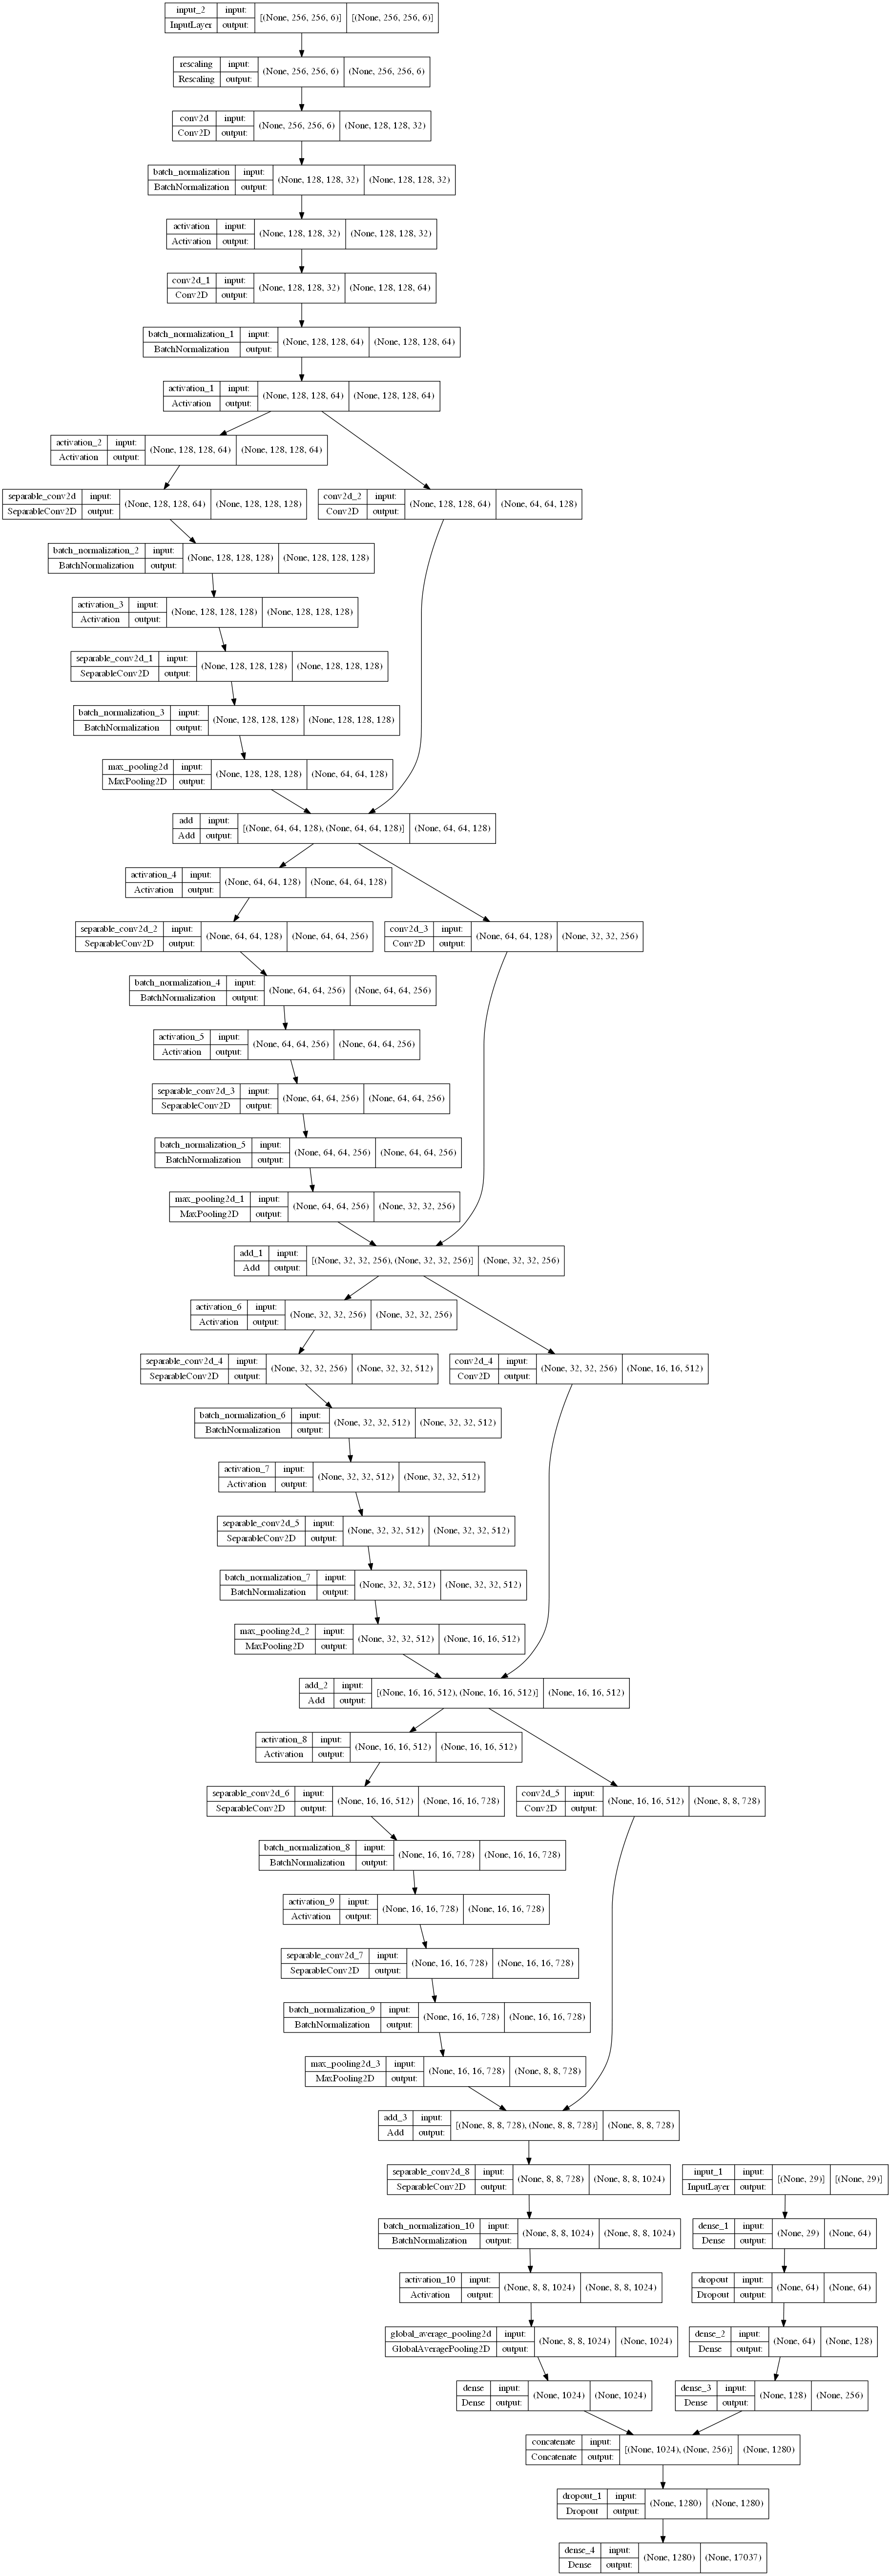

In [52]:
#!pip install pydot

tf.keras.utils.plot_model(model, show_shapes=True)

Here the classical summary of my model structure

In [53]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 6)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  1760        ['rescaling[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 32, 32, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 512)  131584      ['add_1[0][0]']                  
          

In [54]:
# compile model. I used adam with CategoricalCrossentropy loss

model.compile(optimizer='adam',
              loss='CategoricalCrossentropy',
              metrics=['accuracy'])

In [61]:
from time import time # to messure running time

I create a checkpoint to save model weights every epoch via tensorflow callbacks

In [63]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
# To loads the weights from saved model uncoment
#model.load_weights(checkpoint_path)


In [ ]:
# fit Model on testdata Could also be used to continue training
t0 = time()

# Note Batch-size is defined in data generator and has therefore not to be passed to fit
model.fit(train_dataset,
          epochs=5,
          validation_data=val_dataset,
          callbacks=[cp_callback]
         )
print("Time for training %0.3fs." % (time() - t0))

````
Epoch 1/5
  66142/Unknown - 83215s 1s/step - loss: 7.6966 - accuracy: 0.0102  
Epoch 1: saving model to training_1\cp.ckpt
66142/66142 [==============================] - 84432s 1s/step - loss: 7.6966 - accuracy: 0.0102 - val_loss: 10.3538 - val_accuracy: 0.0067
Epoch 2/3
  66142/Unknown - 87823s 1s/step - loss: 7.2613 - accuracy: 0.0146
Epoch 2: saving model to training_1\cp.ckpt
66142/66142 [==============================] - 89191s 1s/step - loss: 7.2613 - accuracy: 0.0146 - val_loss: 10.7435 - val_accuracy: 0.0040
Epoch 3/4
  66142/Unknown - 45066s 681ms/step - loss: 7.1652 - accuracy: 0.0160
Epoch 3: saving model to training_1\cp.ckpt
66142/66142 [==============================] - 46355s 701ms/step - loss: 7.1652 - accuracy: 0.0160 - val_loss: 10.7598 - val_accuracy: 0.0044
Epoch 4/4
66142/66142 [==============================] - ETA: 0s - loss: 7.1470 - accuracy: 0.0170
Epoch 4: saving model to training_1\cp.ckpt
66142/66142 [==============================] - 47351s 716ms/step - loss: 7.1470 - accuracy: 0.0170 - val_loss: 10.7284 - val_accuracy: 0.0061
Epoch 5/5
  66142/Unknown - 51877s 784ms/step - loss: 7.1639 - accuracy: 0.0180
Epoch 5: saving model to training_1\cp.ckpt
66142/66142 [==============================] - 52946s 800ms/step - loss: 7.1639 - accuracy: 0.0180 - val_loss: 10.2720 - val_accuracy: 0.0063
````
We see that the model needs approximate 24 hours of training on my local machine with GPU per epoch. And after optimizing my input pipeline and coding I could get down to approx. 14 hours per epoch.

In [65]:
training_loss = list(model.history.history['loss'])
val_loss = list(model.history.history['val_loss'])
training_acc = list(model.history.history['accuracy'])
val_acc = list(model.history.history['val_accuracy'])
epochs = len(training_loss)

In [ ]:
# continue trainging
additional_epochs = 2

# fit Model on testdata Could also be used to continue training
t0 = time()

# Note Batch-size is defined in data generator and has therefore not to be passed to fit
model.fit(train_dataset,
          epochs=epochs+additional_epochs,
          initial_epoch=epochs,
          validation_data=val_dataset,
          callbacks=[cp_callback]
         )

print("Time for training %0.3fs." % (time() - t0))

Epoch 6/7
   9783/Unknown - 6288s 643ms/step - loss: 7.4103 - accuracy: 0.0082

In [ ]:
training_loss.extend(list(model.history.history['loss']))
val_loss.extend(list(model.history.history['val_loss']))
training_acc.extend(list(model.history.history['accuracy']))
val_acc.extend(list(model.history.history['val_accuracy']))
epochs = len(training_loss)

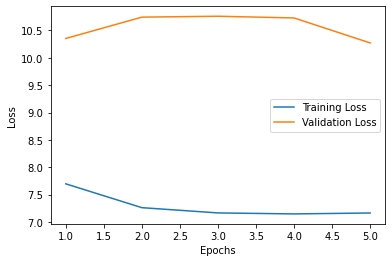

In [282]:
plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.plot(list(range(1,epochs+1,1)), val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

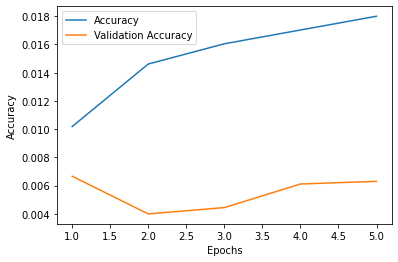

In [283]:
plt.plot(list(range(1,epochs+1,1)), training_acc, label='Accuracy')
plt.plot(list(range(1,epochs+1,1)), val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Make predition on validation set

In [ ]:
s_val = np.zeros((1,30), dtype=int)
i = 0
t0 = time()
for (x1, x2), y in val_dataset:
    y_score = model.predict(x=(x1, x2))
    s_val = np.append(s_val, predict_top_30_set(y_score), axis=0)
    i +=1
    if i % 100 == 0:
        print("batch number:", i)
        
# deletie initial zero line
s_val = numpy.delete(s_val, (0), axis=0)

score_val = top_k_error_rate_from_sets(y_val, s_val, batch_size=16)
print("Top-30 error rate: {:.1%}".format(score_val))
print("Time for validation %0.3fs." % (time() - t0))

### Make final prediction and submission file on test set

Also the prediction with the tensorflow model has to be done in batches to prevent Out Of Memory

In [260]:
s_pred = np.zeros((1,30), dtype=int)
i = 0
t0 = time()
for (x1, x2), y in test_dataset:
    y_score = model.predict(x=(x1, x2))
    s_pred = np.append(s_pred, predict_top_30_set(y_score), axis=0)
    i +=1
    if i % 100 == 0:
        print("batch number:", i)
        
# deletie initial zero line
s_pred = numpy.delete(s_pred, (0), axis=0)
print("Time for final prediction %0.3fs." % (time() - t0))

batch number: 100
batch number: 200
batch number: 300
batch number: 400
batch number: 500
batch number: 600
batch number: 700
batch number: 800
batch number: 900
batch number: 1000
batch number: 1100
batch number: 1200
batch number: 1300
batch number: 1400
batch number: 1500
batch number: 1600
batch number: 1700
batch number: 1800
batch number: 1900
batch number: 2000
batch number: 2100
batch number: 2200
Time for final prediction 974.075s.


````
Time for final prediction 3315.170s.
````
So we see prediction takes roughly 1 hour.

After implementation of prefetching in my data input pipeline and optimizing my batch prediction loop, I was able to reduce the prediction time significant to ~17 minutes.
````
Time for final prediction 986.045s.
````

Lets check correct shape and data type of our predition. It should be 36421 rows (like the oberservations test dataframe) and 30 columns for the top 30 species. Data type should be integer.

In [262]:
s_pred.shape

(36421, 30)

In [263]:
s_pred.dtype

dtype('int64')

In [264]:
# Generate the submission file
t0 = time()
generate_submission_file(SUBMISSION_PATH / "CNN_7_epochs.csv", df_obs_test.index, s_pred)
print("Time for Generate the submission file %0.3fs." % (time() - t0))

Time for Generate the submission file 0.565s.
